In [2]:
# Project Overview
"""
# LogP Predictor: Molecular Property Prediction with Graph Convolutional Networks

This project develops a predictive model for estimating the octanol-water partition coefficient (logP) of chemical compounds using Graph Convolutional Networks (GCNs). LogP is a crucial parameter in drug discovery and environmental chemistry, representing a compound's hydrophobicity.

**Key Features:**
- Uses DeepChem's GraphConvModel for molecular property prediction
- Combines multiple datasets for robust training
- Implements early stopping and learning rate decay
- Provides prediction intervals rather than point estimates
- Includes comprehensive model evaluation
"""

"\n# LogP Predictor: Molecular Property Prediction with Graph Convolutional Networks\n\nThis project develops a predictive model for estimating the octanol-water partition coefficient (logP) of chemical compounds using Graph Convolutional Networks (GCNs). LogP is a crucial parameter in drug discovery and environmental chemistry, representing a compound's hydrophobicity.\n\n**Key Features:**\n- Uses DeepChem's GraphConvModel for molecular property prediction\n- Combines multiple datasets for robust training\n- Implements early stopping and learning rate decay\n- Provides prediction intervals rather than point estimates\n- Includes comprehensive model evaluation\n"

In [14]:
# Environment Setup
# 
import time
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import deepchem as dc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging

# Configure plotting
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

2025-04-30 19:27:55.961286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 19:27:56.138155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-30 19:27:56.138179: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-04-30 19:27:56.177782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 19:27:57.018920: W tensorflow/stream_executor/platform/de

In [15]:
# Data Loading and Exploration
"""
### 3.1 Load and Combine Datasets
We'll use two datasets:
1. DeepChem's Lipophilicity dataset
2. A custom logP dataset
"""

# Load the datasets
data_urls = [
    "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv",
    "/home/mounir/Downloads/logP_dataset.csv"  # Assuming this is in the same directory
]

dfs = []
for url in data_urls:
    df = pd.read_csv(url)
    # Standardize column names
    if 'exp' in df.columns:  # Lipophilicity dataset
        df = df.rename(columns={'exp': 'logP'})
    dfs.append(df)

# Combine datasets
combined_df = pd.concat(dfs, ignore_index=True)
original_count = len(combined_df)

In [16]:
#  Data Cleaning and Validation
# Validate SMILES strings
def is_valid_smiles(smiles):
    try:
        return Chem.MolFromSmiles(smiles) is not None
    except:
        return False

valid_mask = combined_df['smiles'].apply(is_valid_smiles)
combined_df = combined_df[valid_mask]

# Validate logP values
combined_df = combined_df[~combined_df['logP'].isna()]
combined_df = combined_df[np.isfinite(combined_df['logP'])]

# Remove extreme outliers
combined_df = combined_df[(combined_df['logP'] >= -10) & (combined_df['logP'] <= 10)]

# Report cleaning results
print(f"Original dataset size: {original_count}")
print(f"After cleaning: {len(combined_df)}")
print(f"Removed {original_count - len(combined_df)} invalid entries ({((original_count - len(combined_df))/original_count)*100:.2f}%)")

Original dataset size: 18812
After cleaning: 18812
Removed 0 invalid entries (0.00%)


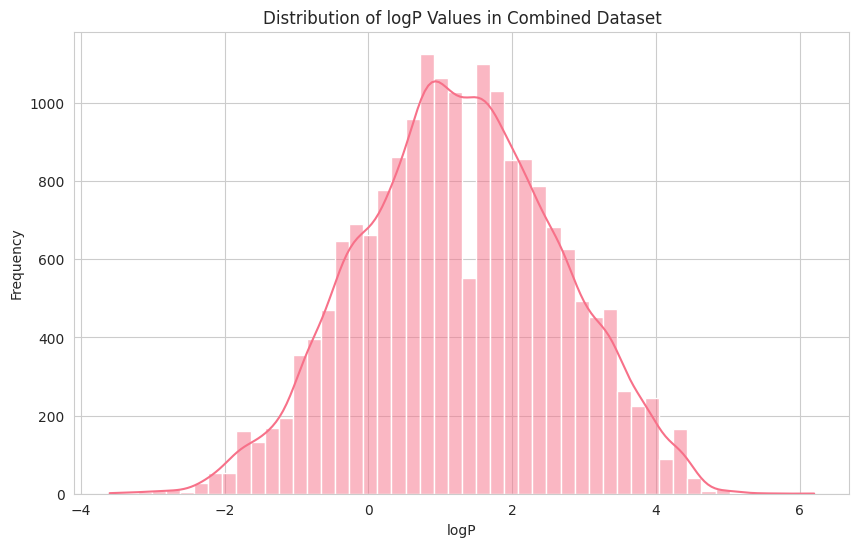

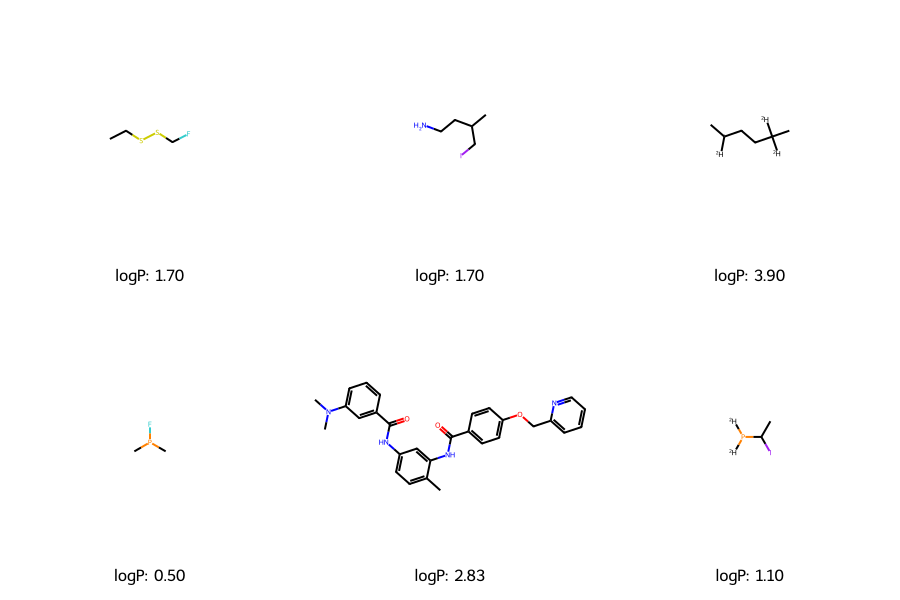

In [10]:
# Dataset Visualization
# Plot distribution of logP values
plt.figure()
sns.histplot(combined_df['logP'], bins=50, kde=True)
plt.title('Distribution of logP Values in Combined Dataset')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.show()

# %%
# Visualize some example molecules
sample_molecules = combined_df.sample(6, random_state=42)['smiles'].values
mols = [Chem.MolFromSmiles(smiles) for smiles in sample_molecules]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), 
                          legends=[f"logP: {combined_df[combined_df['smiles'] == s]['logP'].values[0]:.2f}" 
                                  for s in sample_molecules])
display(img)

In [17]:
# Model Implementation: Featurization

# Initialize featurizer
featurizer = dc.feat.ConvMolFeaturizer()

# Featurize molecules
features = featurizer.featurize(combined_df['smiles'].apply(Chem.MolFromSmiles))
valid_features = [f for f in features if f is not None]

# Create DeepChem dataset
dataset = dc.data.NumpyDataset(
    X=np.array(valid_features),
    y=combined_df['logP'].values[:len(valid_features)]
)

INFO:deepchem.feat.base_classes:Featurizing datapoint 0
INFO:deepchem.feat.base_classes:Featurizing datapoint 1000
INFO:deepchem.feat.base_classes:Featurizing datapoint 2000
INFO:deepchem.feat.base_classes:Featurizing datapoint 3000
INFO:deepchem.feat.base_classes:Featurizing datapoint 4000
INFO:deepchem.feat.base_classes:Featurizing datapoint 5000
INFO:deepchem.feat.base_classes:Featurizing datapoint 6000
INFO:deepchem.feat.base_classes:Featurizing datapoint 7000
INFO:deepchem.feat.base_classes:Featurizing datapoint 8000
INFO:deepchem.feat.base_classes:Featurizing datapoint 9000
INFO:deepchem.feat.base_classes:Featurizing datapoint 10000
INFO:deepchem.feat.base_classes:Featurizing datapoint 11000
INFO:deepchem.feat.base_classes:Featurizing datapoint 12000
INFO:deepchem.feat.base_classes:Featurizing datapoint 13000
INFO:deepchem.feat.base_classes:Featurizing datapoint 14000
INFO:deepchem.feat.base_classes:Featurizing datapoint 15000
INFO:deepchem.feat.base_classes:Featurizing datapoint

In [18]:
# Model Architecture

# Configure learning rate decay
lr_schedule = dc.models.optimizers.ExponentialDecay(
    initial_rate=0.001,
    decay_rate=0.95,
    decay_steps=1000
)

# Initialize the model
model = dc.models.GraphConvModel(
    n_tasks=1,
    mode='regression',
    graph_conv_layers=[128, 128, 64],
    dense_layer_size=256,
    dropout=0.3,
    batch_size=32,
    optimizer_kwargs={'learning_rate': lr_schedule}
)

2025-04-30 19:38:22.332771: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-30 19:38:22.332819: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-30 19:38:22.332857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mounir-HP-ProBook-430-G5): /proc/driver/nvidia/version does not exist
2025-04-30 19:38:22.333296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Training Setup
# Split the dataset
splitter = dc.splits.RandomSplitter()
train, valid, test = splitter.train_valid_test_split(
    dataset,
    frac_train=0.7,
    frac_valid=0.15,
    frac_test=0.15,
    seed=42
)

# Training parameters
max_epochs = 200
patience = 20

INFO:deepchem.splits.splitters:Computing train/valid/test indices


In [20]:
# Model Training

# Training loop with early stopping
train_r2_scores = []
valid_r2_scores = []
best_score = -float('inf')
no_improve = 0
start_time = time.time()

for epoch in tqdm(range(max_epochs), desc="Training"):
    model.fit(train, nb_epoch=1)
    
    # Evaluate on training and validation sets
    train_r2 = model.evaluate(train, [dc.metrics.Metric(dc.metrics.pearson_r2_score)])['pearson_r2_score']
    valid_r2 = model.evaluate(valid, [dc.metrics.Metric(dc.metrics.pearson_r2_score)])['pearson_r2_score']
    
    train_r2_scores.append(train_r2)
    valid_r2_scores.append(valid_r2)
    
    # Early stopping logic
    if valid_r2 > best_score:
        best_score = valid_r2
        no_improve = 0
        model.save_checkpoint()
    else:
        no_improve += 1
        
    if no_improve >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

Training:   0%|                                         | 0/200 [00:00<?, ?it/s]/home/mounir/logp_env/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_14:0", shape=(96,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_13:0", shape=(96, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/mounir/logp_env/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_2/Reshape_17:0", shape=(492,), dtype=int32), values=Tensor("gradient_tape/


Early stopping at epoch 97

Training completed in 1106.48 seconds


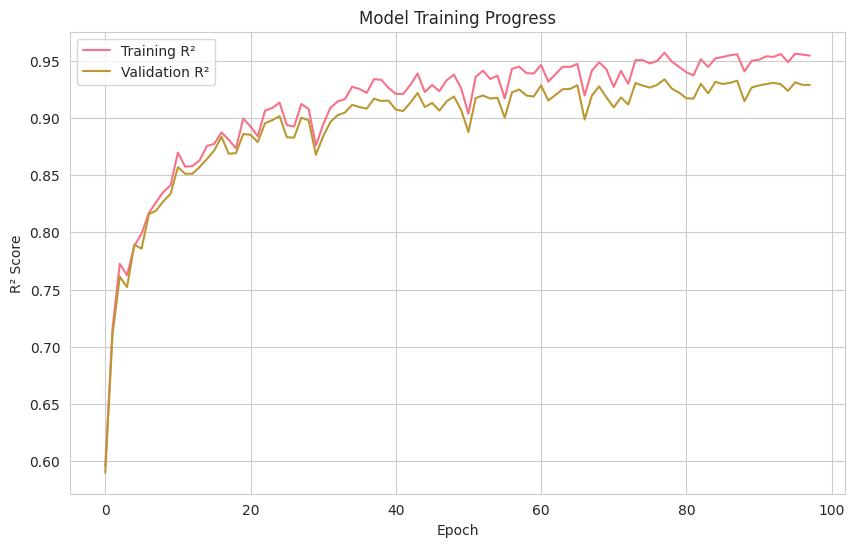

In [21]:
# Training Progress Visualization
# %%
# Plot training progress
plt.figure()
plt.plot(train_r2_scores, label='Training R²')
plt.plot(valid_r2_scores, label='Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Model Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Final Evaluation
# %%
# Evaluate on test set
metrics = [
    dc.metrics.Metric(dc.metrics.pearson_r2_score),
    dc.metrics.Metric(dc.metrics.mean_absolute_error)
]

train_results = model.evaluate(train, metrics)
valid_results = model.evaluate(valid, metrics)
test_results = model.evaluate(test, metrics)

# Create results DataFrame
results_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'R² Score': [train_results['pearson_r2_score'], valid_results['pearson_r2_score'], test_results['pearson_r2_score']],
    'MAE': [train_results['mean_absolute_error'], valid_results['mean_absolute_error'], test_results['mean_absolute_error']]
})

# Display results
print("\nModel Performance:")
display(results_df)

INFO:deepchem.metrics.metric:computed_metrics: [0.9543003154934284]
INFO:deepchem.metrics.metric:computed_metrics: [0.22705216268350212]
INFO:deepchem.metrics.metric:computed_metrics: [0.9287256190469455]
INFO:deepchem.metrics.metric:computed_metrics: [0.26468370703007416]
INFO:deepchem.metrics.metric:computed_metrics: [0.9323327722477394]
INFO:deepchem.metrics.metric:computed_metrics: [0.2603690499072587]



Model Performance:


,Dataset,R² Score,MAE
0,Training,0.954300,0.227052
1,Validation,0.928726,0.264684
2,Test,0.932333,0.260369


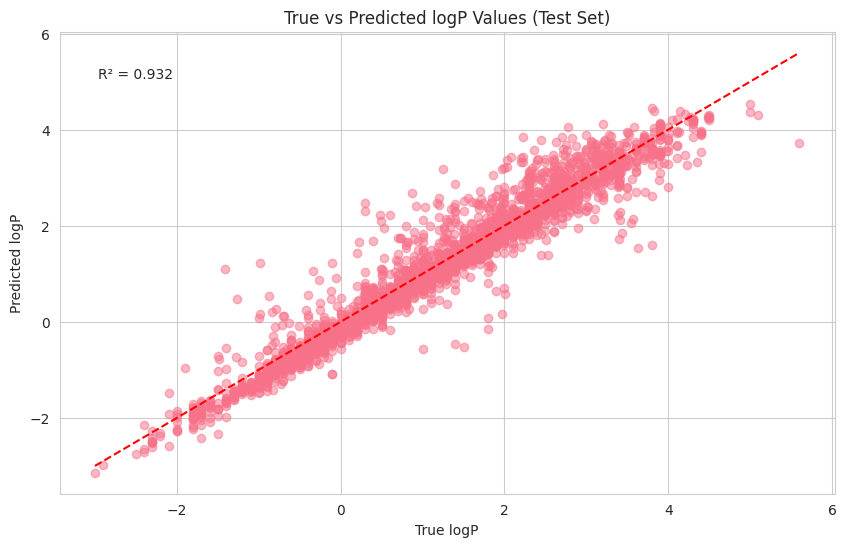

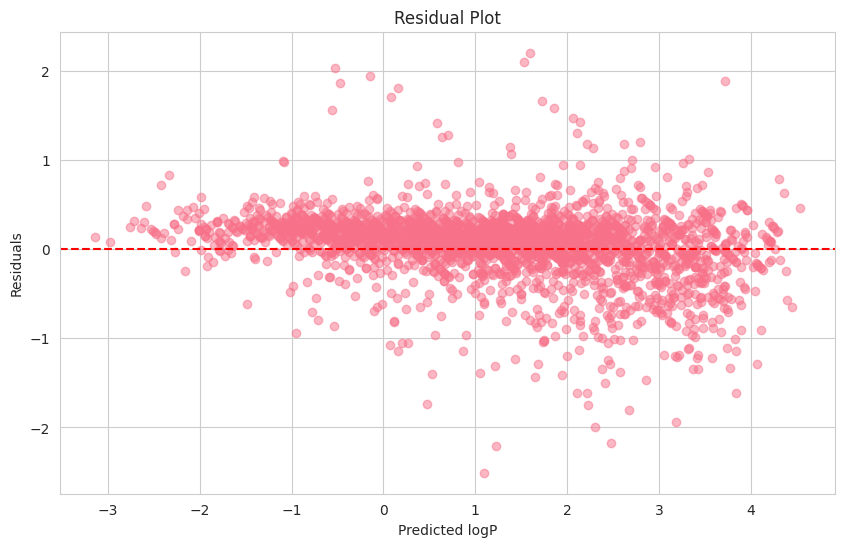

In [23]:
# Prediction Visualization
# %%
# Make predictions on test set
test_preds = model.predict(test).flatten()
test_true = test.y

# Scatter plot of true vs predicted values
plt.figure()
plt.scatter(test_true, test_preds, alpha=0.5)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'r--')
plt.xlabel('True logP')
plt.ylabel('Predicted logP')
plt.title('True vs Predicted logP Values (Test Set)')
plt.grid(True)

# Add R² to plot
r2 = test_results['pearson_r2_score']
plt.text(0.05, 0.9, f'R² = {r2:.3f}', transform=plt.gca().transAxes)
plt.show()

# Residual plot
residuals = test_true - test_preds
plt.figure()
plt.scatter(test_preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted logP')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

In [25]:
from IPython.display import display, clear_output
from ipywidgets import widgets
from rdkit import Chem
from rdkit.Chem import Draw
import deepchem as dc

def predict_logP_interval_direct(smiles, model, featurizer):
    """Predict logP range for a given SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    
    # Featurize the input SMILES
    features = featurizer.featurize([smiles])
    
    # Convert to DeepChem Dataset
    dataset = dc.data.NumpyDataset(features)
    
    # Make prediction
    prediction = model.predict(dataset)[0][0]
    return prediction - 0.5, prediction + 0.5  # Fixed interval of ±0.5

def launch_simple_predictor_interface(model, featurizer, dataset_df=None):
    """Launch interactive prediction interface with explicit model and featurizer"""
    smiles_input = widgets.Text(
        value='CCO',  # Default example
        placeholder='Enter SMILES string (e.g., CCO for ethanol)',
        description='SMILES:',
        layout=widgets.Layout(width='80%')
    )
    
    predict_button = widgets.Button(
        description="Predict", 
        button_style='info',
        tooltip='Click to predict logP'
    )
    output = widgets.Output()

    def make_prediction(_):
        with output:
            clear_output(wait=True)
            smiles = smiles_input.value.strip()
            if not smiles:
                print("Please enter a SMILES string.")
                return
            
            try:
                # Check if molecule exists in our dataset
                if dataset_df is not None and smiles in dataset_df['smiles'].values:
                    actual = dataset_df[dataset_df['smiles'] == smiles]['logP'].values[0]
                    print(f"Known compound - Actual logP: {actual:.2f}")
                
                # Make prediction
                interval = predict_logP_interval_direct(smiles, model, featurizer)
                mol = Chem.MolFromSmiles(smiles)
                
                if mol:
                    # Display molecule image
                    display(Draw.MolToImage(mol, size=(300, 300)))
                    
                    # Display prediction results
                    print(f"\nPredicted logP range: {interval[0]:.2f} to {interval[1]:.2f}")
                    print(f"Most likely value: {(interval[0] + interval[1])/2:.2f}")
                    
                    # Add interpretation
                    if interval[1] < 0:
                        print("\nInterpretation: Highly hydrophilic (water-soluble)")
                    elif interval[0] < 1:
                        print("\nInterpretation: Moderately hydrophilic")
                    elif interval[1] < 3:
                        print("\nInterpretation: Balanced solubility")
                    elif interval[0] < 5:
                        print("\nInterpretation: Moderately hydrophobic")
                    else:
                        print("\nInterpretation: Highly hydrophobic (lipid-soluble)")
                else:
                    print("Invalid SMILES string - could not parse molecule")
            except Exception as e:
                print(f"Prediction error: {str(e)}")

    predict_button.on_click(make_prediction)

    # Create the interface layout
    display(widgets.VBox([
        widgets.HTML("<h2 style='color:#1f77b4;'>LogP Predictor Interface</h2>"),
        widgets.HTML("<p>Enter a SMILES string to predict its octanol-water partition coefficient (logP)</p>"),
        widgets.HBox([smiles_input, predict_button]),
        output
    ]))

# Launch the interface with your existing model and featurizer
launch_simple_predictor_interface(model, featurizer, combined_df)

In [3]:
pip list 

Package                      Version
---------------------------- --------------
absl-py                      2.2.2
anyio                        4.9.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
attrs                        25.3.0
babel                        2.17.0
beautifulsoup4               4.13.4
bleach                       6.2.0
cachetools                   5.5.2
certifi                      2025.1.31
cffi                         1.17.1
charset-normalizer           3.4.1
comm                         0.2.2
contourpy                    1.3.1
cycler                       0.12.1
debugpy                      1.8.14
decorator                    5.2.1
deepchem                     2.7.1
defusedxml                   0.7.1
exceptiongroup               1.2.2
executing                    2.2.0
fastjsonschema               2.2